In [244]:
import os
import random
import librosa
import librosa.display
import random
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay, roc_curve, auc, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

STEP ONE

In [245]:
random.seed(28)

dataset_dir = 'Dataset/'

angry_files = []
fear_files = []
happy_files = []
sad_files = []

#new directories
train_dir = "Training/"
test_dir = "Testing/"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

label_map = {"angry": 0, "fear": 1, "happy": 2, "sad": 3}

In [246]:
for emotion, label in label_map.items():

    audio_files = os.listdir(os.path.join(dataset_dir, emotion))
    random.shuffle(audio_files)
    train_files = audio_files[:70]
    test_files = audio_files[70:]
    
    for file_name in train_files:
        src_path = os.path.join(dataset_dir, emotion, file_name)
        dst_path = os.path.join(train_dir, file_name)
        shutil.copy(src_path, dst_path)
   
    for file_name in test_files:
        src_path = os.path.join(dataset_dir, emotion, file_name)
        dst_path = os.path.join(test_dir, file_name)
        shutil.copy(src_path, dst_path)

STEP TWO

In [247]:
#Label Distribution

emotion_count = {"angry": 0, "fear": 0, "happy": 0, "sad": 0}

for file_name in os.listdir(train_dir):
    emotion_wav = file_name.split("_")[2]
    emotion = emotion_wav.split(".")[0]
    emotion_count[emotion] += 1

print(emotion_count)

{'angry': 70, 'fear': 70, 'happy': 70, 'sad': 70}


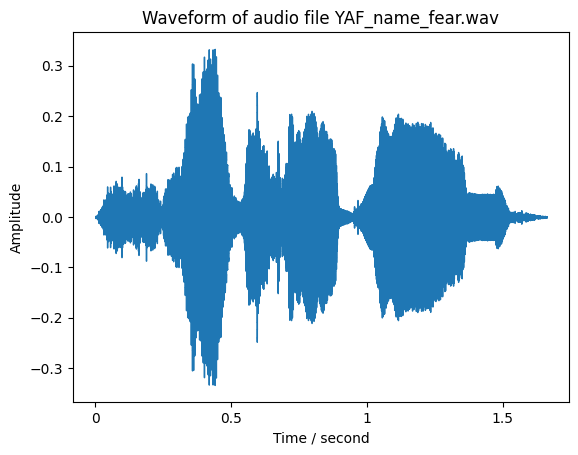

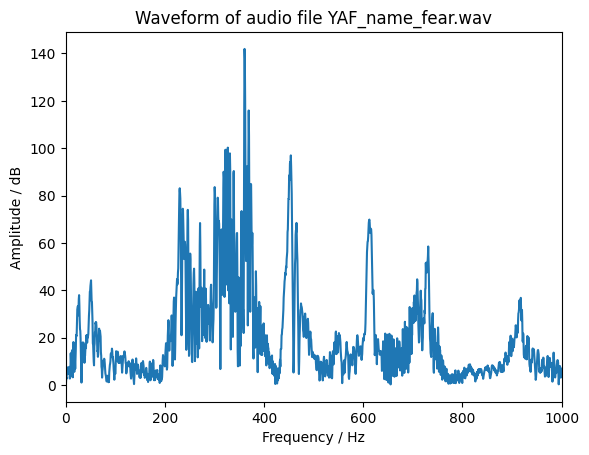

In [248]:
import librosa
import librosa.display

train_list = os.listdir(train_dir)
test_list = os.listdir(test_dir)
random_file = random.choice(train_list)
sample_path = os.path.join(train_dir, random_file)

#golang flashbacks
sample, sr = librosa.load(sample_path)

plt.figure(1)
librosa.display.waveshow(y = sample, sr=sr)
plt.title(f"Waveform of audio file {random_file}")
plt.xlabel("Time / second")
plt.ylabel("Amplitude")
plt.show()

# plot audio files in frequency domain
k = np.arange(len(sample))
T = len(sample)/sr
freq = k/T

DATA_0 = np.fft.fft(sample)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.title(f"Waveform of audio file {random_file}")
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()

Audio(data = sample, rate = sr)

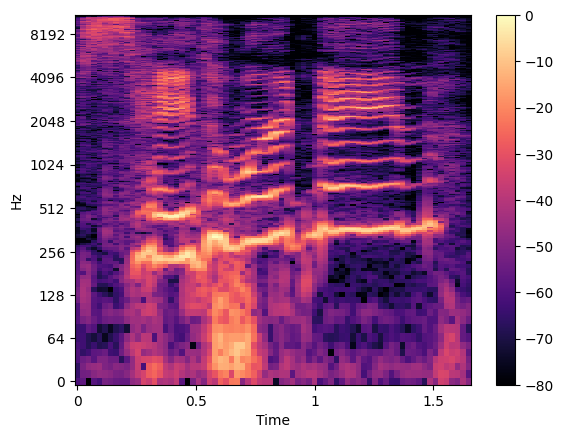

In [249]:
D = librosa.stft(sample) # stft of y
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

STEP THREE: AUDIO FEATURE EXTRACTION

[0.0019832  0.00647423 0.01112319 0.01467988 0.01551833 0.01282411
 0.01316256 0.01392958 0.01414966 0.01370076 0.01027992 0.01620528
 0.02311866 0.02690028 0.03618046 0.04721435 0.05135492 0.05635745
 0.06036665 0.05693217 0.04935762 0.03423237 0.01758171 0.01789104
 0.04233776 0.05657604 0.05304013 0.03849197 0.0292639  0.03181984
 0.03482034 0.04683032 0.04503004 0.04569178 0.04890832 0.0484305
 0.04880404 0.04360285 0.02981856 0.01165232 0.00455097 0.00585379
 0.01203551 0.02112464 0.02828516 0.03638795 0.04232189 0.04230165
 0.0417529  0.040389   0.04004565 0.04043723 0.04042835 0.04018687
 0.03809926 0.03577272 0.03373139 0.03125296 0.02660272 0.0199129
 0.01817844 0.01863066 0.01922352 0.01990763 0.0195311  0.01242011
 0.00443132 0.00243198 0.00207668 0.00153528 0.0009728  0.00048244]
   Loudness
0  0.001983
1  0.006474
2  0.011123
3  0.014680
4  0.015518


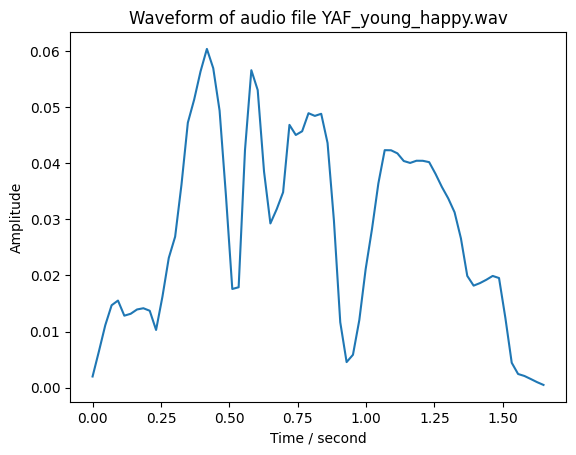

        ZCR
0  0.285156
1  0.473633
2  0.675293
3  0.766113
4  0.794434


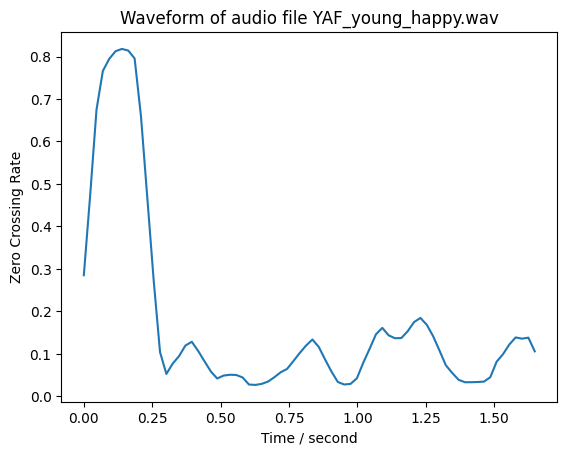

In [250]:
#loudness
df_loudness = pd.DataFrame()
S, phase = librosa.magphase(librosa.stft(sample))
rms = librosa.feature.rms(S=S)
print(rms[0])
df_loudness['Loudness'] = rms[0]
print(df_loudness.head(5))
plt.figure(4)
times = librosa.times_like(rms)
plt.plot(times, rms[0])
plt.title(f"Waveform of audio file {file_name}")
plt.xlabel("Time / second")
plt.ylabel("Amplitude")
plt.show()

#zero crossing rate
df_zero_crossing_rate = pd.DataFrame()
zcr = librosa.feature.zero_crossing_rate(y=sample)
df_zero_crossing_rate['ZCR'] = zcr[0]
print(df_zero_crossing_rate.head(5))
plt.figure(6)
times = librosa.times_like(zcr)
plt.plot(times, zcr[0])
plt.title(f"Waveform of audio file {file_name}")
plt.xlabel("Time / second")
plt.ylabel("Zero Crossing Rate")
plt.show()

In [251]:
def acoustic_feature_extraction(file_path):
    samples, sr = librosa.load(file_path)

    emotion_label = file_path.split('_')[2].replace('.wav', '')

    df_mfccs = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=12)
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]

    df_chroma = pd.DataFrame()
    chromagram = librosa.feature.chroma_stft(y=samples, sr=sr)
    for n_chroma in range(len(chromagram)):
        df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]

    df_mel_spectrogram = pd.DataFrame()
    mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=sr, n_mels=12)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]

    feature_matrix = pd.concat([df_mfccs, df_chroma, df_mel_spectrogram], axis=1)

    return feature_matrix, emotion_label

STEP FOUR: MORE EXTRACTION AND FEATURE PROCESSING

In [252]:

train_features = []
emotion_list_train = []
for file_name in train_list:
    file_path = os.path.join(train_dir, file_name)
    features, emotion_label = acoustic_feature_extraction(file_path)
    train_features.append(features.values)
    emotion_list_train.append(emotion_label)

test_features = []
emotion_list_test = []
for file_name in test_list:
    file_path = os.path.join(test_dir, file_name)
    features, emotion_label = acoustic_feature_extraction(file_path)
    test_features.append(features.values)
    emotion_list_test.append(emotion_label)

emotion_lab = file_path.split('_')[2].replace('.wav', '')

In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

x_train = train_features
x_train = np.asarray(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], -1))
y_train = emotion_list_train

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

x_test = test_features
x_test = np.asarray(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], -1))
x_test_scaled = scaler.transform(x_test)

y_test = emotion_list_test

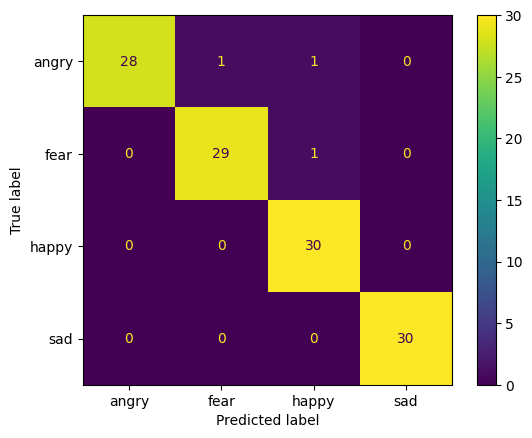

              precision    recall  f1-score   support

       angry       1.00      0.93      0.97        30
        fear       0.97      0.97      0.97        30
       happy       0.94      1.00      0.97        30
         sad       1.00      1.00      1.00        30

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [254]:
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay, roc_curve, auc, r2_score

mod_randFor = RandomForestClassifier()
mod_randFor.fit(x_train_scaled, y_train)
pred_r = mod_randFor.predict(x_test_scaled)
cmr = confusion_matrix(y_test, pred_r)
disp = ConfusionMatrixDisplay(confusion_matrix=cmr, display_labels=mod_randFor.classes_)
disp.plot()
plt.show()

# tn, fp, fn, tp = cmr.ravel()
# n = tp + tn + fp + fn
# accuracy = (tp + tn) / n
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1 = 2 * (precision * recall) / (precision + recall)
# print(accuracy, precision, recall, f1)

# pred_r = mod_randFor.predict_proba(x_test_scaled)[:,1]
# fpr, tpr, _ = roc_curve(y_test, pred_r)
# aucr = auc(fpr, tpr)
# print(aucr)

# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

class_report = classification_report(y_test, pred_r)
print(class_report)

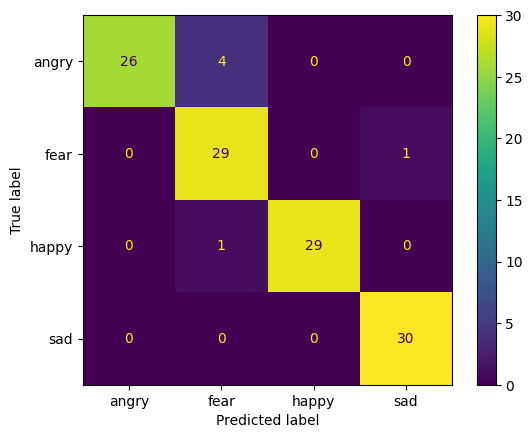

              precision    recall  f1-score   support

       angry       1.00      0.87      0.93        30
        fear       0.85      0.97      0.91        30
       happy       1.00      0.97      0.98        30
         sad       0.97      1.00      0.98        30

    accuracy                           0.95       120
   macro avg       0.96      0.95      0.95       120
weighted avg       0.96      0.95      0.95       120



In [255]:
mod_svm = SVC(probability = True)
mod_svm.fit(x_train_scaled,y_train)
pred_s = mod_svm.predict(x_test_scaled)
cms = confusion_matrix(y_test, pred_s)
disp = ConfusionMatrixDisplay(confusion_matrix=cms, display_labels=mod_svm.classes_)
disp.plot()
plt.show()

# pred_r = mod_randFor.predict_proba(x_test_scaled)[:,1]
# fpr, tpr, _ = roc_curve(y_test, pred_r)
# aucr = auc(fpr, tpr)
# print(aucr)

# plt.plot(fpr,tpr)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

class_report = classification_report(y_test, pred_s)
print(class_report)

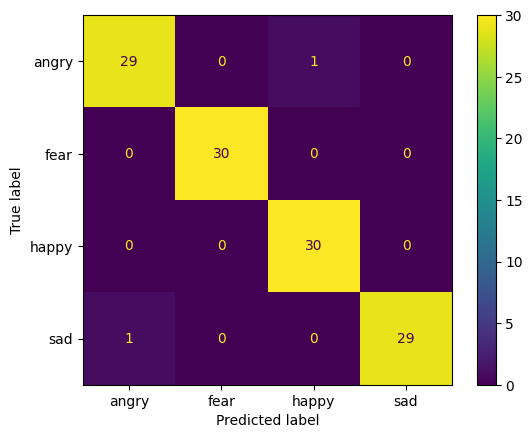

              precision    recall  f1-score   support

       angry       0.97      0.97      0.97        30
        fear       1.00      1.00      1.00        30
       happy       0.97      1.00      0.98        30
         sad       1.00      0.97      0.98        30

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [256]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=28)
gbc.fit(x_train_scaled, y_train)
gbc_pred = gbc.predict(x_test_scaled)
cms = confusion_matrix(y_test, gbc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cms, display_labels=mod_svm.classes_)
disp.plot()
plt.show()

class_report = classification_report(y_test, gbc_pred)
print(class_report)